In [2]:
import pandas as pd
from makeit.utilities.io import name_parser
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if mo
from tqdm import tqdm
import urllib

In [12]:

from sklearn.preprocessing import MultiLabelBinarizer
import pickle


# Load dataset and clean trees

In [4]:
###clean trees
import pickle
import numpy as np
with open("all_trees_cleaned.pkl",'r') as ATC:
    feasible_trees = pickle.load(ATC)
    
def get_stepwise_fsc_from_tree(fsc=[],tree={}):
    if 'is_reaction' in tree.keys():
        fsc.append(tree['forward_score'])
    for child in tree['children']:
        get_stepwise_fsc_from_tree(fsc,child)
    return(fsc)
def nonzero_mul(x):
    prod = 1
    for element in x:
        if element>=0.05:
            prod = prod*element
    return(prod)
trees_to_keep = []
cum_score_list = []
cum_score_with_penalty = []
contains_zero = []
for i, tree in enumerate(feasible_trees):
    if '.' in tree['tree']['smiles']:
        continue
    fsc = get_stepwise_fsc_from_tree(fsc=[],tree=tree['tree'])
    low_prob_count = sum([1 for sc in fsc if sc<0.05])
    if low_prob_count>1:
        continue
    elif low_prob_count==1:
        trees_to_keep.append(i)
        cum_score_list.append(nonzero_mul(fsc))
        cum_score_with_penalty.append(nonzero_mul(fsc)/20)
        contains_zero.append(True)
    else: 
        trees_to_keep.append(i)
        cum_score_list.append(np.prod(fsc))
        cum_score_with_penalty.append(np.prod(fsc))
        contains_zero.append(False)

feasible_trees = [feasible_trees[i] for i in trees_to_keep]
# 

In [5]:
print(len(feasible_trees))

193597


In [13]:
def parse_context(context):
    context_combine_ion = context.replace('].[','<>')
    context_sep = context_combine_ion.split('.')
    parsed_context = [c.replace('<>','].[') for c in context_sep if c is not '']
    return parsed_context
def get_chemical_table_from_routes(routes, contexts):
    # all_chemicals = get_all_chemicals_in_all_routes(routes)
    # print(all_chemicals)
    # print(len(all_chemicals))
    all_routes_chemical_only = []
    all_routes_target = []
    all_routes_score = []
    for route in routes:
        route_target = route['chemicals'][0]['SMILES']
        route_chemical_only = [chemical['SMILES'] for chemical in route['chemicals'] if chemical['is_starting']]
        all_routes_chemical_only.append(route_chemical_only)
        all_routes_target.append(route_target)
        all_routes_score.append(route['score'])
    ohe = MultiLabelBinarizer()
    ohe_context = MultiLabelBinarizer()
    # ohe.fit(all_chemicals)
    # print('transformed')
    all_routes_chemical_onehot = ohe.fit_transform(all_routes_chemical_only)
    all_routes_context_onehot = ohe_context.fit_transform(contexts)
    chemical_smiles = list(ohe.classes_)
    context_smiles = list(ohe_context.classes_)
    return (all_routes_target, all_routes_chemical_onehot, chemical_smiles,all_routes_score, all_routes_context_onehot, context_smiles)

def get_chemicals_from_tree(tree, path = [],):
    path.append({'SMILES':tree['smiles'],
                 'is_starting': False})
    if not tree['children']:
        path[-1]['is_starting']=True
        pass
    else:
        for child in tree['children']:
            [get_chemicals_from_tree(child_chem, path) for child_chem in child['children']]
    return path

def get_context_from_tree(tree, path = [],):
    if not tree['children']:
        pass
    else:
        for child in tree['children']:
            context = child['context']
            [path.extend(parse_context(context[i])) for i in [1,2,3] if context[i]!='']
            [get_context_from_tree(child_chem, path) for child_chem in child['children']]
    return list(set(path))

all_routes = [{'chemicals':get_chemicals_from_tree(tree['tree'],path = []),'score':tree['score']} for tree in feasible_trees if tree['tree']['children']]
all_routes_contexts = [get_context_from_tree(tree['tree'],path = []) for tree in feasible_trees if tree['tree']['children']]
        
(all_routes_target,all_routes_chemical_onehot,chemical_smiles, all_routes_score, all_routes_context_onehot, context_smiles) = get_chemical_table_from_routes(all_routes, all_routes_contexts)
index_list_all_routes = range(len(all_routes))
context_smiles = ['context_'+smiles for smiles in context_smiles]
dataset = pd.DataFrame(all_routes_chemical_onehot, columns = chemical_smiles)
dataset_context = pd.DataFrame(all_routes_context_onehot, columns = context_smiles)
dataset['target'] = all_routes_target
dataset['index'] = index_list_all_routes
dataset['score'] = cum_score_with_penalty

In [96]:
dataset = dataset.assign(**dataset_context)

In [97]:
chemicals_list = list(dataset)
# print(chemicals_list)
target_list = list(dataset['target'])
# chemicals_list.remove('Unnamed: 0')
chemicals_list.remove('target')
chemicals_list.remove('score')
chemicals_list.remove('index')
chemicals_list_no_context = [chemical for chemical in chemicals_list if 'context_' not in chemical]


chemicals_list_index = range(len(chemicals_list))
chemicals_dict = dict(zip(chemicals_list_index, chemicals_list))
chemicals_list_index_no_context = range(len(chemicals_list_no_context))
chemicals_dict_no_context = dict(zip(chemicals_list_index_no_context,chemicals_list_no_context))
print(len(chemicals_list),len(chemicals_list_no_context), len(set(target_list)))

(3910, 3340, 99)


In [6]:
results_folder = "WHO_99_new_penalty/"

with open(results_folder+"selected_path_la05",'r') as X1:
    path_list_x1 = pickle.load(X1)
with open(results_folder+"shortest_path_list.pickle",'r') as X10:
    shortest_path_list = pickle.load(X10)
    
    

In [10]:
def get_max_depth(tree, depths = [0], current_depth = 0):
    if not tree['children']:
        depths.append(current_depth)
    else: current_depth+=0.5
    for child in tree['children']:
        get_max_depth(child, depths=depths, current_depth = current_depth)
    return max(depths)

print(get_max_depth(feasible_trees[1]['tree']))

2.0


In [11]:
all_cum_score_list = []
depth_list = []
# for i, tree in enumerate(feasible_trees):
#     fsc = get_stepwise_fsc_from_tree(fsc=[],tree=tree['tree'])
#     depth = get_max_depth(tree['tree'],depths= [0],current_depth=0)
# #     print(depth)
#     low_prob_count = sum([1 for sc in fsc if sc<0.05])
#     depth_list.append(depth)
#     all_cum_score_list.append(np.prod(fsc))
# print(max(depth_list))
# print(np.mean(depth_list),len(all_cum_score_list))
trees_to_keep = []
cum_score_list = []
cum_score_with_penalty = []
contains_zero = []
for i, tree in enumerate(feasible_trees):
    fsc = get_stepwise_fsc_from_tree(fsc=[],tree=tree['tree'])
    low_prob_count = sum([1 for sc in fsc if sc<0.05])
    if low_prob_count>1:
        continue
    elif low_prob_count==1:
        trees_to_keep.append(i)
        cum_score_list.append(nonzero_mul(fsc))
        cum_score_with_penalty.append(nonzero_mul(fsc)/2.71828)
        contains_zero.append(True)
    else: 
        trees_to_keep.append(i)
        cum_score_list.append(np.prod(fsc))
        cum_score_with_penalty.append(np.prod(fsc))
        contains_zero.append(False)
        
len_sc = [cum_score_with_penalty[i] for i in range(len(cum_score_with_penalty))]

dataset['len_sc'] = len_sc

dataset['index']  = range(dataset.shape[0])
shortest_path_dataset = dataset.loc[dataset.groupby('target',as_index=False)['len_sc'].idxmax()]
# shortest_path_dataset = dataset.sort_values('len_sc',ascending=False).groupby('target',as_index=False).agg('first')
# print(sorted(list(shortest_path_dataset['index'])))

[0, 212, 960, 9498, 17315, 25710, 33582, 33592, 33811, 33830, 33870, 34080, 34661, 42308, 42406, 47824, 47829, 48908, 48962, 48988, 49042, 49262, 52073, 52742, 56231, 56540, 62787, 63055, 65944, 68561, 70312, 70361, 70533, 70754, 73117, 75158, 75245, 75387, 75398, 75479, 75832, 75909, 75941, 75999, 76195, 80369, 84647, 84651, 85062, 87107, 87136, 92488, 93237, 93543, 94068, 94209, 94221, 94237, 95628, 100911, 103810, 104580, 107493, 109128, 109189, 111179, 111848, 112970, 113616, 113914, 114035, 114252, 114453, 119468, 124068, 129083, 129089, 129338, 129956, 130074, 130104, 132110, 132624, 132833, 133102, 133611, 134192, 134319, 134636, 134880, 136189, 140164, 140762, 143831, 148316, 156152, 164660, 171403, 177056, 177198, 182516, 182672, 188157, 194119, 194284]


In [13]:
print(len(len_sc))

194347


In [98]:
selected_path_dataset_1xscore = dataset.iloc[path_list_x1,:]
shortest_path_dataset = dataset.iloc[shortest_path_list,:]

In [50]:
agg_1xscore = selected_path_dataset_1xscore.agg('sum')
use_chem_1xscore = agg_1xscore[agg_1xscore>=1]


In [53]:
agg_shortest = shortest_path_dataset.agg('sum')
use_chem_shortest = agg_shortest[agg_shortest>=1]

print((use_chem_shortest['BrCC1CO1']))

2


In [17]:

chem_list_1xscore = list(use_chem_1xscore.keys())
chem_list_shortest = list(use_chem_shortest.keys())

# print(chem_list_shortest)

81
130
109
106
(106, 106)
('3', '3', '3', '3', '2', '2', '2', '2', '2', '2', '2', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1')


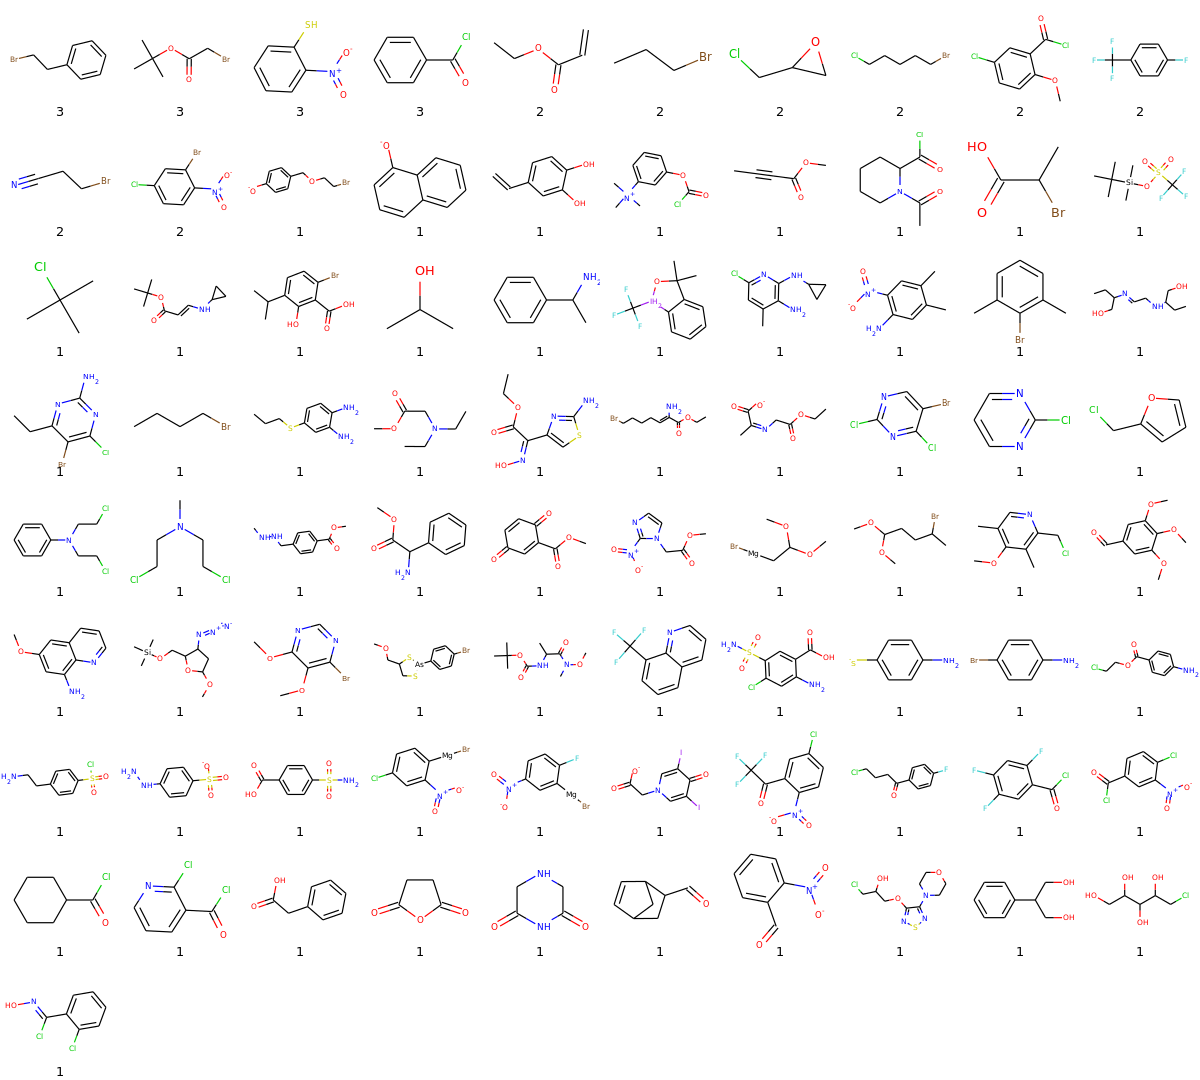

In [41]:
chem_set_1xscore = set(chem_list_1xscore)
chem_set_shortest = set(chem_list_shortest)

inter_chem_sets = chem_set_1xscore.intersection(chem_set_shortest)

chem_list_1xscore_only = sorted(list(chem_set_1xscore-inter_chem_sets),key=lambda s: s.lower())
chem_list_shortest_only = sorted(list(chem_set_shortest-inter_chem_sets),key=lambda s: s.lower())

mol_list_1xscore = []
mol_list_shortest = []
ct_list_1xscore = []
ct_list_shortest = []
ctr = 0
for chem in chem_list_1xscore_only:
    if 'context_' not in chem:
        ctr+=1
        mol_list_1xscore.append(Chem.MolFromSmiles(chem))
        ct_list_1xscore.append(str(agg_1xscore[chem]))
print ctr

ctr = 0
for chem in chem_list_shortest_only:
    if 'context_' not in chem:
#         print(chem) 
        mol_list_shortest.append(Chem.MolFromSmiles(chem))
        ct_list_shortest.append(str(agg_shortest[chem]))
        ctr+=1
print(ctr)

print(len([chem for chem in list(inter_chem_sets) if 'context_' not in chem]))

mol_list_mutual =[]
ct_list_mutual = []
ctr = 0
for chem in sorted([chem for chem in list(inter_chem_sets) if 'context_' not in chem], key=lambda s: s.lower()):
    if chem in ['index', 'score', 'target', 'Unnamed: 0', 'len_sc']:
        continue
    if 'context_' not in chem:
#         print(chem) 
        mol_list_mutual.append(Chem.MolFromSmiles(chem))
        ct_list_mutual.append(';'.join([str(agg_shortest[chem]),str(agg_1xscore[chem])]))
        ctr+=1
print(ctr)

print(len(mol_list_mutual), len(ct_list_mutual))

mol_list_1xscore, ct_list_1xscore = zip(*sorted(zip(mol_list_1xscore,ct_list_1xscore),key=lambda x: x[1], reverse=True))
mol_list_shortest, ct_list_shortest = zip(*sorted(zip(mol_list_shortest,ct_list_shortest),key=lambda x: x[1], reverse=True))
mol_list_mutual, ct_list_mutual = zip(*sorted(zip(mol_list_mutual,ct_list_mutual),key=lambda x: x[1][2], reverse=True))

print(ct_list_1xscore)
DrawingOptions.radicalSymbol = '.'
Chem.Draw.MolsToGridImage(mol_list_1xscore,molsPerRow=10, subImgSize=(120, 120),legends = ct_list_1xscore)
# Chem.Draw.MolsToGridImage(mol_list_shortest,molsPerRow=10, subImgSize=(120, 120),legends = ct_list_shortest)
# Chem.Draw.MolsToGridImage(mol_list_mutual,molsPerRow=10, subImgSize=(120, 120),legends = ct_list_mutual)

In [22]:
##chemical freq dictionary##
def construct_tree_for_d3_visualization(tree,depth,new_tree = {}):
    if 'is_chemical' in tree.keys():
#         new_tree['smiles']='http://askcos.mit.edu/draw/smiles/'+str(urllib.quote(tree['smiles'],safe= ''))
        new_tree['smiles']='http://askcos.mit.edu/draw/smiles/'+str(tree['smiles']).replace('#','%23')
        new_tree['rc_type'] ='chemical'
        try:
            new_tree['freq'] = chemical_freq_dict[tree['smiles']]
        except:
            pass
        new_tree['smiles']=str(new_tree['smiles'])
    else:
        new_tree['smiles']='http://askcos.mit.edu/draw/smiles/'
        new_tree['names']=''
        new_tree['score']='%.3f' % tree['forward_score']
        new_tree['_id']=int(depth)
        for i in [1,2,3]:
            for c in tree['context'][i].split('.'):   
                if 'Reaxys' not in c:
                    new_tree['smiles']+='.'+str(urllib.quote(c,safe= '')).replace('#','%23')
                elif 'Reaxys Name' in c:
                    new_tree['names']+=str(c)[11:]+'.'
                else:
                    new_tree['names']+=str(c)
        if new_tree['smiles'] == "http://askcos.mit.edu/draw/smiles/...":
            new_tree['smiles'] = ''
        new_tree['names']=str(new_tree['names'])
        new_tree['rc_type']='reaction'
    new_tree['children'] = []
    if tree['children']:
        for child in tree['children']:
            new_tree['children'].append({})
            construct_tree_for_d3_visualization(child,depth+0.5, new_tree['children'][-1])
    return new_tree

selected_trees = {'name': 'dummy_root','children':[]}
# for path_id in sorted(selected_path_list):
# for i,path_id in enumerate(path_list_x1):
for i,path_id in enumerate(path_list_x1):
    selected_trees['children'].append(
        construct_tree_for_d3_visualization(feasible_trees[path_id]['tree'], depth = 0.5, new_tree = {})
    )
    selected_trees['children'][-1]['score'] = ('%.3f' % cum_score_with_penalty[path_id])
    selected_trees['children'][-1]['_id'] = ('T%d' % i)
    
print(selected_trees)


####IMPORTANT####
##paste the output below to the html template file for tree visualization!!!####

{'name': 'dummy_root', 'children': [{'smiles': 'http://askcos.mit.edu/draw/smiles/O=C1c2c(O)cccc2Cc2cccc(O)c21', '_id': 'T0', 'score': '0.024', 'children': [{'smiles': 'http://askcos.mit.edu/draw/smiles/..CC%28%3DO%29O.%5BZn%5D', 'score': '0.488', 'names': '', '_id': 1, 'children': [{'smiles': 'http://askcos.mit.edu/draw/smiles/O=C1c2cccc(O)c2C(=O)c2c(O)cccc21', 'children': [{'smiles': 'http://askcos.mit.edu/draw/smiles/..Cl%5BAlH3%5D%28Cl%29Cl.%5BNa%2B%5D.%5BCl-%5D.', 'score': '0.000', 'names': '', '_id': 2, 'children': [{'smiles': 'http://askcos.mit.edu/draw/smiles/O=C1OC(=O)c2c(O)cccc21', 'children': [], 'rc_type': 'chemical'}, {'smiles': 'http://askcos.mit.edu/draw/smiles/Oc1ccccc1', 'children': [], 'rc_type': 'chemical'}], 'rc_type': 'reaction'}], 'rc_type': 'chemical'}], 'rc_type': 'reaction'}], 'rc_type': 'chemical'}, {'smiles': 'http://askcos.mit.edu/draw/smiles/Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1', '_id': 'T1', 'score': '1.000', 'children': [{'smiles': 'http://askcos.mit.edu/draw/

In [80]:
# chemical = "NCc1ccccc1"
# chemical = "CC(C)(C)OC(=O)OC(=O)OC(C)(C)C"
chemical = "Brc1ccccc1"
print(list(shortest_path_dataset[shortest_path_dataset[chemical]==1]['target']))

print(list(selected_path_dataset_1xscore[selected_path_dataset_1xscore[chemical]==1]['target']))

['CN(C)CCC=C1c2ccccc2CCc2ccccc21', 'CCC1(c2ccccc2)C(=O)NC(=O)NC1=O']
['CCC(=O)C(CC(C)N(C)C)(c1ccccc1)c1ccccc1', 'CN(C)CCC=C1c2ccccc2CCc2ccccc21', 'CNC(C)C(O)c1ccccc1', 'CCC1(c2ccccc2)C(=O)NC(=O)NC1=O', 'OC(CCN1CCCCC1)(c1ccccc1)C1CC2C=CC1C2', 'COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1']


In [71]:
selected_path_dataset_1xscore.iloc[98]

BrBr                                                                 0
BrC(Br)(Br)Br                                                        0
BrCC1CO1                                                             0
BrCC1COc2ccccc2O1                                                    0
BrCC1OCOc2ccc1cc2Br                                                  0
BrCC1SCCCS1                                                          0
BrCCBr                                                               0
BrCCCCCBr                                                            0
BrCCCCCCBr                                                           0
BrCCCCCI                                                             0
BrCCCCCOC1CCCCO1                                                     0
BrCCCOC1CCCCO1                                                       0
BrCCOC1CCCCO1                                                        0
BrCCSSc1ccccn1                                                       0
BrCC[M

In [77]:
# agg_1xscore
for i in tqdm(range(selected_path_dataset_1xscore.shape[0])):
    no_chem = 0
    no_chem_overlap = 0
    no_chem_separate = 0 
    no_chem_separate_overlap = 0
    for j in selected_path_dataset_1xscore.columns:
        if j in use_chem_1xscore.keys():
            if selected_path_dataset_1xscore.iloc[i][j]==1:
                no_chem+=1
                no_chem_overlap+=use_chem_1xscore[j]>1
    
    for j in shortest_path_dataset.columns:
        if j in use_chem_shortest.keys():
            if shortest_path_dataset.iloc[i][j]==1:
                no_chem_separate+=1
                no_chem_separate_overlap+=use_chem_shortest[j]>1
    overlap_frac = float(no_chem_overlap)/no_chem
    overlap_frac_separate = float(no_chem_separate_overlap)/no_chem_separate
    
    print(selected_path_dataset_1xscore.iloc[i]['target'],overlap_frac,overlap_frac_separate)




  0%|          | 0/99 [00:00<?, ?it/s]


  1%|          | 1/99 [00:01<02:12,  1.36s/it]

('O=C1c2c(O)cccc2Cc2cccc(O)c21', 0.5, 0.5)





  2%|▏         | 2/99 [00:02<02:12,  1.36s/it]

('Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1', 0.0, 0.0)





  3%|▎         | 3/99 [00:04<02:11,  1.37s/it]

('CCN(CC)CCNC(=O)c1ccc(N)cc1', 1.0, 0.5)





  4%|▍         | 4/99 [00:05<02:11,  1.39s/it]

('CCOC(=O)C1(c2ccccc2)CCN(C)CC1', 0.75, 0.3333333333333333)





  5%|▌         | 5/99 [00:06<02:10,  1.38s/it]

('CC(C)NCC(O)COc1ccc(CC(N)=O)cc1', 0.6666666666666666, 0.6666666666666666)





  6%|▌         | 6/99 [00:08<02:08,  1.38s/it]

('CNCCC(Oc1ccc(C(F)(F)F)cc1)c1ccccc1', 1.0, 0.4)





  7%|▋         | 7/99 [00:09<02:06,  1.38s/it]

('CC1(C)SC2C(NC(=O)COc3ccccc3)C(=O)N2C1C(=O)[O-]', 0.5, 0.0)





  8%|▊         | 8/99 [00:11<02:04,  1.37s/it]

('CNNCc1ccc(C(=O)NC(C)C)cc1', 0.5, 0.5)





  9%|▉         | 9/99 [00:12<02:03,  1.37s/it]

('CN1CCCN=C1C=Cc1cccs1', 0.5, 0.5)





 10%|█         | 10/99 [00:13<02:02,  1.38s/it]

('O=C(Cn1ccnc1[N+](=O)[O-])NCc1ccccc1', 0.5, 0.5)





 11%|█         | 11/99 [00:15<02:01,  1.38s/it]

('COc1ccc2nc(S(=O)Cc3ncc(C)c(OC)c3C)[nH]c2c1', 0.0, 0.0)





 12%|█▏        | 12/99 [00:16<01:59,  1.38s/it]

('Cc1cc(C(C)(C)C)cc(C)c1CC1=NCCN1', 0.6666666666666666, 0.5714285714285714)





 13%|█▎        | 13/99 [00:17<01:58,  1.38s/it]

('N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1', 0.5, 0.0)





 14%|█▍        | 14/99 [00:19<01:56,  1.38s/it]

('O=C(OCc1ccccc1)c1ccccc1', 1.0, 0.5)





 15%|█▌        | 15/99 [00:20<01:55,  1.37s/it]

('CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12', 0.5, 0.0)





 16%|█▌        | 16/99 [00:22<01:53,  1.37s/it]

('CN=C(NC#N)NCCSCc1nc[nH]c1C', 0.0, 0.0)





 17%|█▋        | 17/99 [00:23<01:52,  1.37s/it]

('CCC(=O)C(CC(C)N(C)C)(c1ccccc1)c1ccccc1', 0.75, 0.5)





 18%|█▊        | 18/99 [00:24<01:50,  1.37s/it]

('c1ccc(C2CN3CCSC3=N2)cc1', 0.5, 0.5)





 19%|█▉        | 19/99 [00:26<01:49,  1.36s/it]

('Cc1ncc2n1-c1ccc(Cl)cc1C(c1ccccc1F)=NC2', 0.0, 0.0)





 20%|██        | 20/99 [00:27<01:47,  1.36s/it]

('CN(C)CCC=C1c2ccccc2CCc2ccccc21', 0.6666666666666666, 0.3333333333333333)





 21%|██        | 21/99 [00:28<01:40,  1.29s/it]

('O=C(Nc1ccc([N+](=O)[O-])cc1Cl)c1cc(Cl)ccc1O', 0.5, 0.0)





 22%|██▏       | 22/99 [00:29<01:41,  1.32s/it]

('CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23', 0.5, 0.5)





 23%|██▎       | 23/99 [00:31<01:41,  1.33s/it]

('O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1', 0.3333333333333333, 0.0)





 24%|██▍       | 24/99 [00:32<01:40,  1.34s/it]

('CNC(=C[N+](=O)[O-])NCCSCc1ccc(CN(C)C)o1', 0.0, 0.0)





 25%|██▌       | 25/99 [00:34<01:39,  1.34s/it]

('CC1=C(C(=O)O)N2C(=O)C(NC(=O)C(N)c3ccccc3)C2SC1', 0.3333333333333333, 0.0)





 26%|██▋       | 26/99 [00:35<01:38,  1.35s/it]

('NS(=O)(=O)c1cc(C(=O)O)c(NCc2ccco2)cc1Cl', 0.0, 0.0)





 27%|██▋       | 27/99 [00:36<01:38,  1.37s/it]

('COc1cc2nc(N3CCN(C(=O)C4COc5ccccc5O4)CC3)nc(N)c2cc1OC', 0.3333333333333333, 0.0)





 28%|██▊       | 28/99 [00:38<01:37,  1.37s/it]

('COC(=O)C(N)Cc1ccc(O)c(O)c1', 0.5, 0.0)





 29%|██▉       | 29/99 [00:39<01:35,  1.37s/it]

('CCN(CC)CCNC(=O)c1cc(Cl)c(N)cc1OC', 0.6666666666666666, 0.5)





 30%|███       | 30/99 [00:40<01:34,  1.37s/it]

('Nc1nc(N)nc(Nc2ccc([As]3SCC(CO)S3)cc2)n1', 0.5, 0.0)





 31%|███▏      | 31/99 [00:42<01:32,  1.37s/it]

('COc1cc(NC(C)CCCN)c2ncccc2c1', 0.3333333333333333, 0.0)





 32%|███▏      | 32/99 [00:43<01:31,  1.37s/it]

('CC(C)NCC(O)COc1cccc2ccccc12', 0.6666666666666666, 0.6666666666666666)





 33%|███▎      | 33/99 [00:45<01:30,  1.38s/it]

('O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O', 0.3333333333333333, 0.3333333333333333)





 34%|███▍      | 34/99 [00:46<01:29,  1.37s/it]

('CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21', 0.6666666666666666, 0.3333333333333333)





 35%|███▌      | 35/99 [00:47<01:27,  1.37s/it]

('Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1', 0.5, 0.0)





 36%|███▋      | 36/99 [00:49<01:26,  1.37s/it]

('CCn1cc(C(=O)O)c(=O)c2ccc(C)nc21', 0.5, 0.0)





 37%|███▋      | 37/99 [00:50<01:24,  1.37s/it]

('CC(C)(C)NCC(O)c1ccc(O)c(CO)c1', 0.5, 0.5)





 38%|███▊      | 38/99 [00:51<01:23,  1.36s/it]

('CNC(C)C(O)c1ccccc1', 0.6666666666666666, 0.0)





 39%|███▉      | 39/99 [00:53<01:21,  1.36s/it]

('COC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1ccccc1[N+](=O)[O-]', 0.5, 0.0)





 40%|████      | 40/99 [00:54<01:20,  1.36s/it]

('CCC1(c2ccccc2)C(=O)NC(=O)NC1=O', 0.75, 0.75)





 41%|████▏     | 41/99 [00:55<01:18,  1.36s/it]

('COc1ncnc(NS(=O)(=O)c2ccc(N)cc2)c1OC', 0.5, 0.0)





 42%|████▏     | 42/99 [00:57<01:17,  1.37s/it]

('CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21', 1.0, 0.3333333333333333)





 43%|████▎     | 43/99 [00:58<01:16,  1.37s/it]

('CN1CCN(C(c2ccccc2)c2ccccc2)CC1', 1.0, 1.0)





 44%|████▍     | 44/99 [01:00<01:15,  1.37s/it]

('CCC(CO)NCCNC(CC)CO', 0.0, 0.0)





 45%|████▌     | 45/99 [01:01<01:12,  1.34s/it]

('CC(C)N=C(N)N=C(N)Nc1ccc(Cl)cc1', 0.3333333333333333, 0.3333333333333333)





 46%|████▋     | 46/99 [01:02<01:11,  1.34s/it]

('O=C1CN=C(c2ccccc2Cl)c2cc([N+](=O)[O-])ccc2N1', 0.6666666666666666, 0.3333333333333333)





 47%|████▋     | 47/99 [01:03<01:06,  1.28s/it]

('Cc1cn(C2C=CC(CO)O2)c(=O)[nH]c1=O', 0.0, 0.0)





 48%|████▊     | 48/99 [01:05<01:05,  1.28s/it]

('CCN(CC)CC(=O)Nc1c(C)cccc1C', 0.5, 0.5)





 49%|████▉     | 49/99 [01:06<01:05,  1.31s/it]

('CC1(C)CC1C(=O)NC(=CCCCCSCC(N)C(=O)O)C(=O)O', 0.0, 0.25)





 51%|█████     | 50/99 [01:07<01:04,  1.32s/it]

('CCCSc1ccc2nc(NC(=O)OC)[nH]c2c1', 0.5, 0.0)





 52%|█████▏    | 51/99 [01:09<01:04,  1.33s/it]

('COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC', 0.0, 0.0)





 53%|█████▎    | 52/99 [01:10<01:03,  1.34s/it]

('CCCN(CCC)S(=O)(=O)c1ccc(C(=O)O)cc1', 0.5, 0.0)





 54%|█████▎    | 53/99 [01:11<01:01,  1.35s/it]

('C[N+](C)(C)CCOC(=O)CCC(=O)OCC[N+](C)(C)C', 0.0, 0.0)





 55%|█████▍    | 54/99 [01:13<01:00,  1.35s/it]

('OC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F', 0.0, 0.0)





 56%|█████▌    | 55/99 [01:14<00:59,  1.36s/it]

('CN(C)CCC(c1ccc(Cl)cc1)c1ccccn1', 0.3333333333333333, 0.3333333333333333)





 57%|█████▋    | 56/99 [01:16<00:58,  1.36s/it]

('Cc1ccc(N(CC2=NCCN2)c2cccc(O)c2)cc1', 0.8333333333333334, 0.5)





 58%|█████▊    | 57/99 [01:17<00:57,  1.36s/it]

('Nc1ccc(S(=O)(=O)c2ccc(N)cc2)cc1', 0.0, 0.0)





 59%|█████▊    | 58/99 [01:18<00:55,  1.36s/it]

('CN(C)C(=O)Oc1cccc([N+](C)(C)C)c1', 0.5, 0.0)





 60%|█████▉    | 59/99 [01:20<00:54,  1.36s/it]

('O=C1OC2(c3ccc(O)cc3Oc3cc(O)ccc32)c2ccccc21', 0.5, 0.25)





 61%|██████    | 60/99 [01:21<00:53,  1.36s/it]

('CCCCNc1ccc(C(=O)OCCN(C)C)cc1', 0.3333333333333333, 0.0)





 62%|██████▏   | 61/99 [01:22<00:51,  1.37s/it]

('CCN(CC)C(=O)N1CCN(C)CC1', 0.6666666666666666, 1.0)





 63%|██████▎   | 62/99 [01:24<00:49,  1.35s/it]

('C=CC1=C(C(=O)O)N2C(=O)C(NC(=O)C(=NOCC(=O)O)c3csc(N)n3)C2SC1', 0.6, 0.0)





 64%|██████▎   | 63/99 [01:25<00:47,  1.32s/it]

('O=C1NC(=O)C(c2ccccc2)(c2ccccc2)N1', 0.6666666666666666, 0.6666666666666666)





 65%|██████▍   | 64/99 [01:26<00:46,  1.34s/it]

('NC(=O)N1c2ccccc2C=Cc2ccccc21', 0.6666666666666666, 0.3333333333333333)





 66%|██████▌   | 65/99 [01:28<00:45,  1.35s/it]

('CCOC(=O)C1=C(COCCN)NC(C)=C(C(=O)OC)C1c1ccccc1Cl', 0.6666666666666666, 0.0)





 67%|██████▋   | 66/99 [01:29<00:44,  1.35s/it]

('O=C(O)C1=CC(=NNc2ccc(S(=O)(=O)Nc3ccccn3)cc2)C=CC1=O', 0.0, 0.0)





 68%|██████▊   | 67/99 [01:30<00:43,  1.35s/it]

('O=C(NC(CO)C(O)c1ccc([N+](=O)[O-])cc1)C(Cl)Cl', 0.0, 0.0)





 69%|██████▊   | 68/99 [01:32<00:42,  1.36s/it]

('CC(CN1c2ccccc2Sc2ccccc21)N(C)C', 1.0, 1.0)





 70%|██████▉   | 69/99 [01:33<00:40,  1.36s/it]

('CC(C)NCC(O)c1ccc(O)c(O)c1', 0.6666666666666666, 0.5)





 71%|███████   | 70/99 [01:34<00:38,  1.32s/it]

('CCN(CCO)CCCC(C)Nc1ccnc2cc(Cl)ccc12', 0.6666666666666666, 0.3333333333333333)





 72%|███████▏  | 71/99 [01:35<00:35,  1.25s/it]

('COc1ccc(Cl)cc1C(=O)NCCc1ccc(S(=O)(=O)NC(=O)NC2CCCCC2)cc1', 0.5, 0.0)





 73%|███████▎  | 72/99 [01:37<00:34,  1.28s/it]

('CCCC(C)C1(CC)C(=O)NC(=S)NC1=O', 0.5, 0.5)





 74%|███████▎  | 73/99 [01:38<00:33,  1.30s/it]

('CC1(C)SC2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O', 0.5, 0.5)





 75%|███████▍  | 74/99 [01:39<00:33,  1.32s/it]

('CC(C)(C)NCC(O)COc1nsnc1N1CCOCC1', 0.5, 0.5)





 76%|███████▌  | 75/99 [01:41<00:31,  1.33s/it]

('O=C(O)CCCc1ccc(N(CCCl)CCCl)cc1', 0.0, 0.0)





 77%|███████▋  | 76/99 [01:42<00:30,  1.34s/it]

('CCCOC(=O)Cn1cc(I)c(=O)c(I)c1', 0.5, 0.0)





 78%|███████▊  | 77/99 [01:44<00:29,  1.34s/it]

('CC(Cc1ccc(O)c(O)c1)(NN)C(=O)O', 0.5, 0.5)





 79%|███████▉  | 78/99 [01:45<00:27,  1.31s/it]

('Cc1ccnc2c1NC(=O)c1cccnc1N2C1CC1', 0.0, 0.0)





 80%|███████▉  | 79/99 [01:46<00:25,  1.25s/it]

('CC(C)Cc1ccc(C(C)C(=O)O)cc1', 0.75, 0.5)





 81%|████████  | 80/99 [01:47<00:23,  1.26s/it]

('CC(C)c1cccc(C(C)C)c1O', 0.6666666666666666, 0.0)





 82%|████████▏ | 81/99 [01:49<00:23,  1.29s/it]

('OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1', 0.0, 0.0)





 83%|████████▎ | 82/99 [01:50<00:22,  1.31s/it]

('CCc1nc(N)nc(N)c1-c1ccc(Cl)cc1', 0.5, 0.0)





 84%|████████▍ | 83/99 [01:51<00:21,  1.33s/it]

('O=C1Nc2ccc(Cl)cc2C(C#CC2CC2)(C(F)(F)F)O1', 0.3333333333333333, 0.3333333333333333)





 85%|████████▍ | 84/99 [01:53<00:19,  1.31s/it]

('COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1C(NC(C)=O)CC2', 0.25, 0.25)





 86%|████████▌ | 85/99 [01:54<00:17,  1.26s/it]

('O=C(OOC(=O)c1ccccc1)c1ccccc1', 1.0, 0.25)





 87%|████████▋ | 86/99 [01:55<00:15,  1.22s/it]

('CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1', 0.5, 0.5)





 88%|████████▊ | 87/99 [01:56<00:14,  1.21s/it]

('O=C1Nc2ccc(Cl)cc2C(c2ccccc2Cl)=NC1O', 1.0, 0.3333333333333333)





 89%|████████▉ | 88/99 [01:57<00:13,  1.26s/it]

('OC(CCN1CCCCC1)(c1ccccc1)C1CC2C=CC1C2', 0.6, 0.4)





 90%|████████▉ | 89/99 [01:59<00:12,  1.30s/it]

('O=C(O)c1cc(=O)c2cc(OCC(O)COc3cccc4oc(C(=O)O)cc(=O)c34)ccc2o1', 0.5, 0.3333333333333333)





 91%|█████████ | 90/99 [02:00<00:11,  1.32s/it]

('CCCCN1CCCCC1C(=O)Nc1c(C)cccc1C', 0.5, 0.0)





 92%|█████████▏| 91/99 [02:02<00:10,  1.34s/it]

('OCCN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc32)CC1', 0.8333333333333334, 0.25)





 93%|█████████▎| 92/99 [02:03<00:09,  1.35s/it]

('CCOC(=O)C(CCc1ccccc1)NC(C)C(=O)N1CCCC1C(=O)O', 0.6, 0.5)





 94%|█████████▍| 93/99 [02:04<00:08,  1.35s/it]

('O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1', 0.75, 0.0)





 95%|█████████▍| 94/99 [02:06<00:06,  1.36s/it]

('Cc1onc(-c2ccccc2Cl)c1C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O', 0.5, 0.25)





 96%|█████████▌| 95/99 [02:07<00:05,  1.36s/it]

('CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21', 1.0, 0.6)





 97%|█████████▋| 96/99 [02:08<00:04,  1.36s/it]

('Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(CC(O)C(O)C(O)CO)c2cc1C', 0.0, 0.0)





 98%|█████████▊| 97/99 [02:10<00:02,  1.36s/it]

('COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1', 0.75, 0.3333333333333333)





 99%|█████████▉| 98/99 [02:11<00:01,  1.36s/it]

('CN1C2CCC1CC(OC(=O)C(CO)c1ccccc1)C2', 0.3333333333333333, 0.3333333333333333)





100%|██████████| 99/99 [02:12<00:00,  1.28s/it]




('Cc1cn(C2CC(N=[N+]=[N-])C(CO)O2)c(=O)[nH]c1=O', 0.0, 0.3333333333333333)


In [99]:
chem_list_1xscore_clean = [c for c in selected_path_dataset_1xscore.columns if c not in ['index', 'score', 'target', 'Unnamed: 0', 'len_sc']]
chem_list_shortest_clean = [c for c in shortest_path_dataset.columns if c not in ['index', 'score', 'target', 'Unnamed: 0', 'len_sc']]
num_chemicals_1xscore = selected_path_dataset_1xscore.loc[:,chem_list_1xscore_clean].sum(axis=1)
num_chemicals_shortest = shortest_path_dataset.loc[:,chem_list_shortest_clean].sum(axis=1)

In [100]:
print(np.mean(num_chemicals_1xscore))
print(np.mean(num_chemicals_shortest))

8.282828282828282
8.414141414141413
